In [1]:
#!pip install gymnasium[atari] gymnasium[accept-rom-license]

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch.optim as optim
import time
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# hyper-parameters
BATCH_SIZE = 128
LR = 0.0005
GAMMA = 0.99
MEMORY_CAPACITY = 45000
MEMORY_START_SIZE = 3000
MEMORY_START_SIZE = MEMORY_START_SIZE if MEMORY_START_SIZE > BATCH_SIZE else BATCH_SIZE
Q_NETWORK_ITERATION = 10

env = gym.make("Breakout-v4", render_mode="rgb_array", obs_type="grayscale")
NUM_ACTIONS = env.action_space.n
shape = (64, 64)
NUM_STATES = shape[0] * shape[1]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape

In [5]:
print('action_space:', env.action_space)
print('observation_space:', env.observation_space)

action_space: Discrete(4)
observation_space: Box(0, 255, (210, 160), uint8)


In [6]:
observation = env.reset()

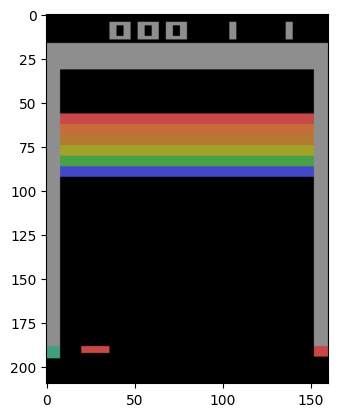

In [7]:
# Check environment
from IPython import display
import matplotlib.pyplot as plt

observation = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    observation, reward, done, _, info = env.step(action)
    img = plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if not done:
        img.remove()

env.close()

In [8]:
def cut_borders(observation):
    return torch.tensor(observation[32:-10, 8:-8], dtype=torch.float).view(1, 168, 144)

def concat_frames(state_sequence):
    sequence_len = state_sequence.shape[0]
    weights = torch.logspace(0, sequence_len / 5, sequence_len, dtype=torch.float)
    weights_sum = weights.sum()
    out = (weights @ state_sequence.view(sequence_len, -1)).view(168, 144) / weights_sum
    out = torchvision.transforms.functional.resize(out.view(1, 1, 168, 144), [shape[0], shape[1]]).view(shape[0], shape[1])
    return out

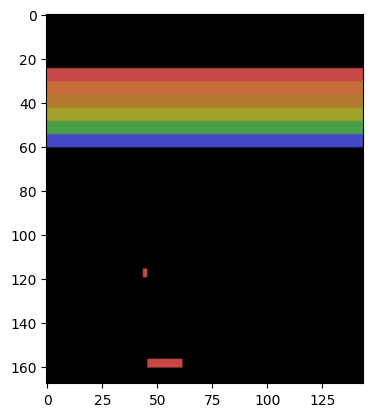

In [9]:
observation = env.reset()[0]
observations = cut_borders(observation)
for i in range(10):
    action = env.action_space.sample()
    observation, reward, done, _, info = env.step(action)
    observations = torch.cat((observations, cut_borders(observation)))
    plt.imshow(env.render()[32:-10, 8:-8])
    display.display(plt.gcf())
    display.clear_output(wait=True)

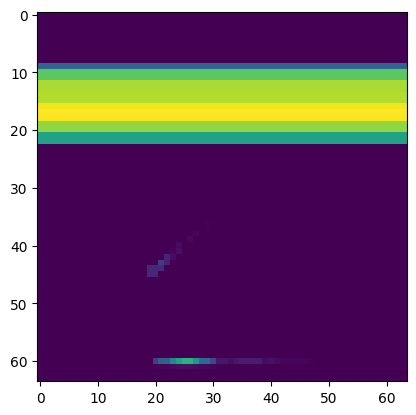

In [10]:
plt.imshow(concat_frames(observations))
plt.show()

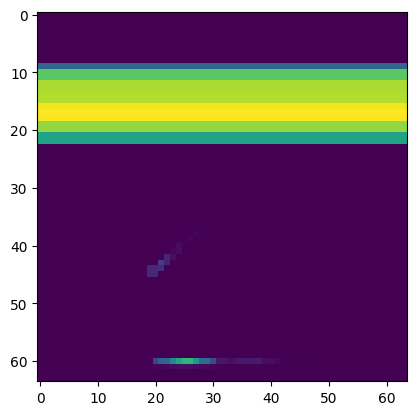

In [11]:
img = concat_frames(observations[-8:])
plt.imshow(img)

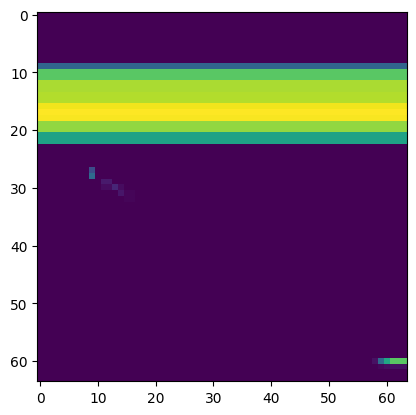

In [12]:
observation = env.reset()[0]
observations = cut_borders(observation)
for i in range(50):
    action = env.action_space.sample()
    observation, reward, done, _, info = env.step(action)
    observations = torch.cat((observations, cut_borders(observation)))
    state = concat_frames(observations[-5:])
    plt.imshow(state)
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [13]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super(ConvBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding=1, kernel_size=(3, 3)),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(dropout),
            nn.ReLU())
        
    def forward(self, x):
        return self.layers(x)

class StateEmbedding(nn.Module):
    def __init__(self, emb_dim=128):
        super(StateEmbedding, self).__init__()
        self.layers = nn.Sequential(ConvBlock(1, 16), ConvBlock(16, 32), ConvBlock(32, 16))
        
        self.conv_emb_size = 16 * (shape[0] // 8) * (shape[1] // 8)
        self.embedding = nn.Linear(self.conv_emb_size, emb_dim)

    def forward(self, x):
        x = x.view(-1, 1, shape[0], shape[1])
        return self.embedding(self.layers(x).view(-1, self.conv_emb_size))

# Q(s, a) -> q
class Net(nn.Module):
    def __init__(self, state_emb_dim=128, inner_emb_dim=128):
        super(Net, self).__init__()
        self.state_embedding = StateEmbedding(state_emb_dim)
        self.layers = nn.Sequential(nn.Linear(state_emb_dim, inner_emb_dim), nn.ReLU(), nn.Linear(inner_emb_dim, NUM_ACTIONS))
        
        self.layers.apply(self.init_weights)

    def forward(self, x):
        state_embedding = self.state_embedding(x)
        return self.layers(state_embedding)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            # m.weight.data.normal_(0, 0.1)
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

class ExperienceReplay:
    def __init__(self, capacity):
        self.MEMORY_CAPACITY = capacity
        self.memory_counter = 0
        self.memory = np.zeros((self.MEMORY_CAPACITY, NUM_STATES * 2 + 2))

    def store_transition(self, state, action, reward, next_state):
        transition = np.hstack((state, [action, reward], next_state))
        index = self.memory_counter % self.MEMORY_CAPACITY
        self.memory[index] = transition
        self.memory_counter += 1

    def get_batch(self, batch_size):
        sample_index = np.random.choice(len(self), batch_size, replace=False)
        batch_memory = self.memory[sample_index]
        batch_state = torch.tensor(batch_memory[:, :NUM_STATES], dtype=torch.float32, device=device)
        batch_action = torch.tensor(batch_memory[:, NUM_STATES:NUM_STATES + 1].astype(int), dtype=torch.long, device=device)
        batch_reward = torch.tensor(batch_memory[:, NUM_STATES + 1:NUM_STATES + 2], dtype=torch.float32, device=device)
        batch_next_state = torch.tensor(batch_memory[:,-NUM_STATES:], dtype=torch.float32, device=device)
        batch_next_state_not_done_mask = ~torch.any(torch.isnan(batch_next_state), dim=1)
        return (batch_state.view(-1, shape[0], shape[1]), batch_action, batch_reward, 
                batch_next_state.view(-1, shape[0], shape[1]),
                batch_next_state_not_done_mask)

    def get_cur_buffer(self):
        return self.memory[:len(self)]

    def __len__(self):
        return self.memory_counter if self.memory_counter < self.MEMORY_CAPACITY else self.MEMORY_CAPACITY


class DQN:
    def __init__(self):
        super(DQN, self).__init__()
        self.possible_actions = list(range(0, NUM_ACTIONS))
        self.eval_net = Net().to(device)
        self.target_net = Net().to(device)

        self.buffer = ExperienceReplay(MEMORY_CAPACITY)

        self.learning_rate = LR
        self.optimizer = optim.Adam(self.eval_net.parameters(), lr=self.learning_rate)

    def get_action(self, state, epsilon):
        if np.random.random() < epsilon:
            return np.random.choice(self.possible_actions, 1)[0]
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            out = self.eval_net(state)
            return out.argmax().item()

    def update(self, num_steps=10):
        step_loss = 0
        for _ in range(num_steps):
            batch_state, batch_action, batch_reward, batch_next_state, next_not_done_mask = self.buffer.get_batch(BATCH_SIZE)
            next_not_done_states = batch_next_state[next_not_done_mask]
            next_state_values = torch.zeros(BATCH_SIZE, device=device)
            q_out = self.eval_net(batch_state)
            q_a = q_out.gather(1, batch_action)
            with torch.no_grad():
                next_state_values[next_not_done_mask] = self.target_net(next_not_done_states).max(1)[0]
            target = batch_reward + GAMMA * next_state_values.unsqueeze(1)
            
            loss = F.smooth_l1_loss(q_a, target.detach())
            step_loss += loss.item()
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return step_loss / num_steps

In [14]:
def train(dqn, all_rewards, all_losses, episodes=2000, print_rate=20, save_every=100, succ_stopping=10, start_episode=0):
    num_of_succeeds = 0
    start_time = time.time()
    for n_epi in range(start_episode, start_episode + episodes):
        first_observation, info = env.reset()
        ep_reward = 0
        epsilon = max(0.02, 0.3 - 0.01 * (n_epi / 100))
        obs_sequence = cut_borders(first_observation)
        for i in range(5):
            action = env.action_space.sample()
            observation, reward, done, _, info = env.step(action)
            obs_sequence = torch.cat((obs_sequence, cut_borders(observation)))
        state = concat_frames(observations)
        while True:
            action = dqn.get_action(state, epsilon)
            if np.random.random() < 0.1:
                action = 1
            next_observation, reward, terminated, truncated, info = env.step(action)
            next_obs_sequence = torch.cat((obs_sequence[1:], cut_borders(next_observation)))
            next_state = concat_frames(next_obs_sequence)
            done = terminated or truncated
            if done:
                next_state = torch.tensor([torch.nan] * NUM_STATES)
            dqn.buffer.store_transition(state.view(-1), action, reward, next_state.view(-1))
            ep_reward += reward
            state = next_state
            obs_sequence = next_obs_sequence
            if done:
                break
        if len(dqn.buffer) >= MEMORY_START_SIZE:
            all_losses.append(dqn.update(10))
        else:
            all_losses.append(0)
        if n_epi != start_episode and n_epi % print_rate == 0:
            end_time = time.time()
            print(f"episode: {n_epi}, mean {print_rate} reward: {sum(all_rewards[-min(print_rate, len(all_rewards)):]) / min(print_rate, len(all_rewards)):.3f}, \
                  mean {print_rate} losses: {sum(all_losses[-min(print_rate, len(all_losses)):]) / min(print_rate, len(all_losses)):.5f}, \
                  epsilon : {epsilon:.4f}, time: {end_time - start_time:.1f} sec")
            start_time = end_time
        all_rewards.append(ep_reward)

        if n_epi % Q_NETWORK_ITERATION == 0:
            dqn.target_net.load_state_dict(dqn.eval_net.state_dict())

        if n_epi % save_every == 0:
            torch.save(dqn.target_net.state_dict(), f'target_net_{n_epi}.pt')
        if truncated:
            num_of_succeeds += 1
        if num_of_succeeds == succ_stopping:
            print(f"Succeeded {num_of_succeeds} times! Stopping...")
            break

In [20]:
dqn = DQN()
all_rewards = []
all_losses = []

In [21]:
start = time.time()
train(dqn, all_rewards, all_losses, episodes=500000, print_rate=250, save_every=500, start_episode=len(all_rewards))
end = time.time()
print(f"Total time: {end - start} sec")


episode: 250, mean 250 reward: 1.604,                   mean 250 losses: 0.03832,                   epsilon : 0.2750, time: 103.8 sec
episode: 500, mean 250 reward: 1.488,                   mean 250 losses: 0.02030,                   epsilon : 0.2500, time: 105.8 sec
episode: 750, mean 250 reward: 1.488,                   mean 250 losses: 0.01897,                   epsilon : 0.2250, time: 102.9 sec
episode: 1000, mean 250 reward: 1.664,                   mean 250 losses: 0.01509,                   epsilon : 0.2000, time: 105.6 sec
episode: 1250, mean 250 reward: 1.604,                   mean 250 losses: 0.01303,                   epsilon : 0.1750, time: 111.8 sec
episode: 1500, mean 250 reward: 1.932,                   mean 250 losses: 0.01118,                   epsilon : 0.1500, time: 111.1 sec
episode: 1750, mean 250 reward: 2.156,                   mean 250 losses: 0.00973,                   epsilon : 0.1250, time: 118.1 sec
episode: 2000, mean 250 reward: 2.192,                   m

KeyboardInterrupt: 

In [23]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_rewards(all_rewards):
    plt.title("Rewards for episodes")
    plt.xlabel("episode")
    plt.ylabel("reward")
    plt.plot(all_rewards)
    plt.plot(moving_average(all_rewards, 30))
    plt.legend(['episode reward', 'moving average at 30 reward'])
    plt.show()
    
def plot_losses(all_losses):
    plt.title("Losses for episodes")
    plt.xlabel("episode")
    plt.ylabel("loss")
    plt.plot(all_losses[30:])
    plt.plot(moving_average(all_losses[30:], 30))
    plt.legend(['episode loss', 'moving average at 30 loss'])
    plt.show()

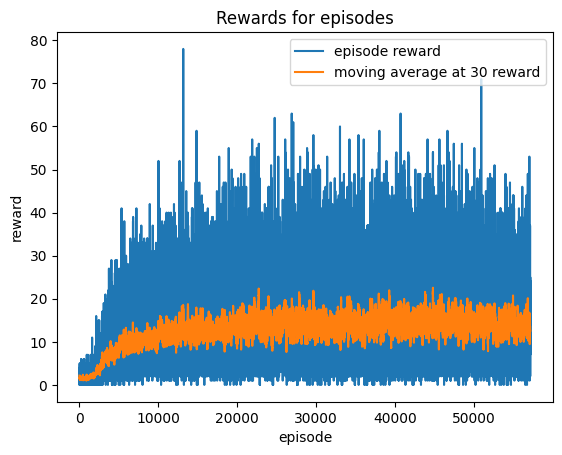

In [24]:
plot_rewards(all_rewards)

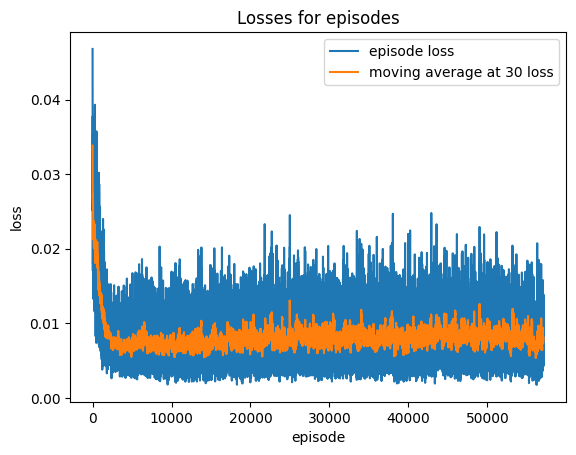

In [25]:
plot_losses(all_losses)

In [ ]:
def load_dqn(target):
    dqn = DQN()
    dqn.target_net.load_state_dict(torch.load(target, map_location=torch.device(device)))
    dqn.eval_net.load_state_dict(torch.load(target, map_location=torch.device(device)))
    return dqn
# dqn_t = load_dqn
# dqn_t.load_model('target_net_55000.pt')
# dqn_t = load_dqn('target_net_55000.pt')
dqn_t = load_dqn('target_net_38000.pt')

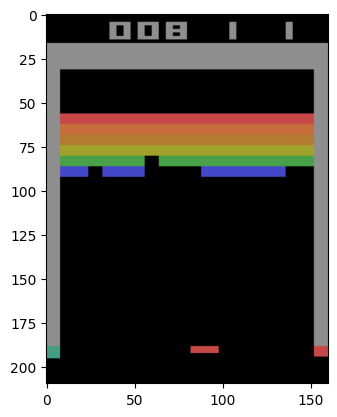

In [20]:
first_observation, info = env.reset()
obs_sequence = cut_borders(first_observation)
for i in range(5):
    action = env.action_space.sample()
    observation, reward, done, _, info = env.step(action)
    obs_sequence = torch.cat((obs_sequence, cut_borders(observation)))
state = concat_frames(observations)
while True:
    action = dqn_t.get_action(state, 0)
    if np.random.random() < 0.1:
        action = 1
    next_observation, reward, done, truncated, info = env.step(action)
    next_obs_sequence = torch.cat((obs_sequence[1:], cut_borders(next_observation)))
    next_state = concat_frames(next_obs_sequence)
    img = plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if not done:
        img.remove()
    state = next_state
    obs_sequence = next_obs_sequence
    if done or truncated:
        break